In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
from skimage.transform import resize, rescale, rotate, setup, warp
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.patches as patches

from skimage.color import rgb2gray

import PIL
from PIL import Image

from google.colab import output

from sklearn.linear_model import LinearRegression

In [0]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 4180 (delta 14), reused 24 (delta 8), pack-reused 4148
Receiving objects: 100% (4180/4180), 384.44 MiB | 11.83 MiB/s, done.
Resolving deltas: 100% (675/675), done.
Checking out files: 100% (796/796), done.


In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

In [17]:
networks = []
batches = os.listdir('/content/Lithuanian_OCR/Trained_model')

for batch in batches:
  if(batch != 'treshold.txt' and batch != '.ipynb_checkpoints'):
    nt = Net(4096, 1500, 300, 3)

    nt.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/' + batch + '/model.pth'))
    nt.eval()

    networks.append(nt)

print("Loaded {} networks".format(len(networks)))

treshold = []

with open('/content/Lithuanian_OCR/Trained_model/treshold.txt') as fp:
   line = fp.readline()
   cnt = 0
   while line:
       treshold.append(line.strip().split(' ')[1])
       line = fp.readline()
       cnt += 1

if(len(treshold) != len(networks)):
  print('ERROR LOADING TRESHOLDS!')

batch-1
batch-2
Loaded 2 networks


In [0]:
def proccess_image(path):
  image = io.imread(path)
  image = rgb2gray(image)
  image = resize(image, (64, 64))
  
  return torch.tensor(image)

def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

def get_result(data):
  idx = get_max_from_tensor(data) - 1

  if(data[idx] > 6):
    return idx + 1
  # No object found
  elif(data[idx] <= 6):
    return 0
  # Best guess is that there is no object
  else:
    return 0

def find_in_array(arr, element):
  idx = 0
  found = []

  for el in arr:
    if(el == element):
      found.append(idx)
    idx += 1

  return found

def prepare_image_for_network(image):
  image = resize(image, (64, 64))

  return image

def parse_letters(letter_idx, network_idx):
  if(network_idx == 0):
    switcher = {
        1: 'A',
        2: 'B',
        3: 'C'
    }
  elif(network_idx == 1):
        switcher = {
        1: 'a',
        2: 'P',
        3: 'u'
    }

  return switcher.get(letter_idx)

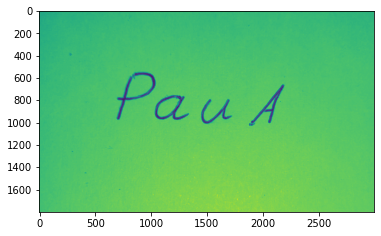

In [19]:
image = io.imread('/content/Lithuanian_OCR/Examples/example3.jpg')

# image = rotate(image, 90)
image = rgb2gray(image)
image = resize(image, (1800, 3000))
plt.imshow(image)

Searching color distances...
Sorting by y...
Removing far point by x axis
Sorting by x...
Removing far point by x axis


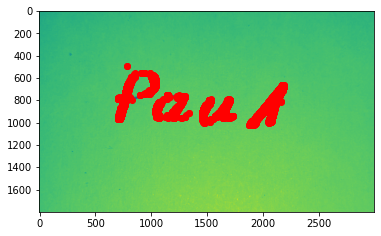

4267


In [20]:
registered_x = []
registered_y = []

print("Searching color distances...")
for y in range(image.shape[0]):
  last_val = image[y][0]
  for x in range(image.shape[1]):
    if(abs(last_val - image[y][x]) >= 0.1):
      registered_x.append(x)
      registered_y.append(y)
    last_val = image[y][x]

# Sorting points by y
print("Sorting by y...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_y)-1):
    if(registered_y[i] > registered_y[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_y)-1):
    if(i != len(registered_y)-1):
      if(abs(registered_y[i+1] - registered_y[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_y[i] - registered_y[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y
  
# Sorting points by x
print("Sorting by x...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_x)-1):
    if(registered_x[i] > registered_x[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_x)-1):
    if(i != len(registered_x)-1):
      if(abs(registered_x[i+1] - registered_x[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_x[i] - registered_x[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y

implot = plt.imshow(image)
plt.scatter(registered_x, registered_y, c='r')
plt.show()

print(len(registered_x))

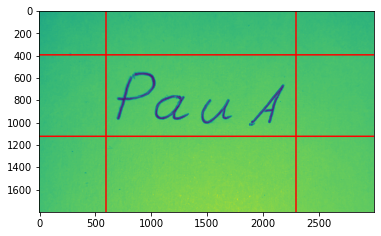

In [21]:
margins = 100

# Finding lowest y point
lowest_y = registered_y[0]
lowest_x = registered_x[0]

highest_y = registered_y[0]
highest_x = registered_x[0]

for i in range(len(registered_x)):
  if(registered_y[i] > highest_y):
    highest_x = registered_x[i]
    highest_y = registered_y[i]

  if(registered_y[i] < lowest_y):
    lowest_x = registered_x[i]
    lowest_y = registered_y[i]

# Finding smallest x point
smallest_x = registered_x[0]
smallest_y = registered_y[0]

biggest_x = registered_x[0]
biggest_y = registered_y[0]

for i in range(len(registered_x)):
  if(registered_x[i] > biggest_x):
    biggest_x = registered_x[i]
    biggest_y = registered_y[i]

  if(registered_x[i] < smallest_x):
    smallest_x = registered_x[i]
    smallest_y = registered_y[i]

implot = plt.imshow(image)
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(highest_y+margins, image.shape[1]), c='r')
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(lowest_y-margins, image.shape[1]), c='r')
plt.axvline(smallest_x-margins, c='r')
plt.axvline(biggest_x+margins, c='r')
plt.show()

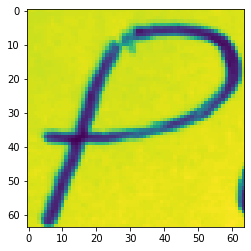

tensor([-10.3265,  -9.9544,  -9.0095], grad_fn=<AddBackward0>)
tensor([-12.6550,  12.4247, -12.5912], grad_fn=<AddBackward0>)
P


In [22]:
img = image[516:975, 672:1050]
# img = image[736:998, 1056:1381]
# img = image[771:1016, 1475:1781]
img = resize(img, (64, 64))
plt.imshow(img)
plt.show()

maxProb = 0
network_idx = 0
MaxRes = 0
for t in range(len(networks)):
  output = networks[t](torch.Tensor(img).flatten().float())
  res = get_result(output)
  prob = output[res - 1]

  print(output)

  if(prob > maxProb):
    maxProb = prob
    network_idx = t
    MaxRes = res

print(parse_letters(MaxRes, network_idx))

In [23]:
letters = []
stepSize = 10

lastRes = 0

picture_start_point = 0
for i in range(int(image.shape[1]/stepSize)):
  img = image[(lowest_y-margins):(highest_y+margins), (picture_start_point):(i*stepSize)]

  if(img.shape[0] > 0 and img.shape[1] > 0):
    reshaped_img = resize(img, (64, 64))

    for idx in range(len(networks)):
      output = networks[idx](torch.Tensor(reshaped_img).flatten().float())
      
      res = get_max_from_tensor(output)

      if(res != lastRes):
        lastRes = res
        picture_start_point = i*stepSize

      if(float(output[res - 1]) > float(treshold[idx])):
        if(parse_letters(res - 1, idx) != None and output[res - 1] > 0):
          print("Result: {} Prob: {}".format(parse_letters(res - 1, idx), output[res - 1]))
          letters.append(parse_letters(res - 1, idx))

Result: a Prob: 4.4310760498046875
Result: a Prob: 3.5530943870544434
Result: a Prob: 2.2326087951660156
Result: P Prob: 9.864421844482422
Result: P Prob: 13.686089515686035
Result: P Prob: 13.240839958190918
Result: A Prob: 2.2905311584472656
Result: P Prob: 6.619230270385742
Result: P Prob: 12.652676582336426
Result: A Prob: 3.0586097240448
Result: A Prob: 6.896751403808594
Result: P Prob: 2.9854631423950195
Result: P Prob: 5.696580410003662
Result: a Prob: 1.632287859916687
Result: a Prob: 3.7638626098632812
Result: a Prob: 1.0664734840393066
Result: a Prob: 1.5977294445037842
Result: a Prob: 1.8449196815490723


In [24]:
# Removing duplicates from array
answer = []
last_letter = ""
for x in letters:
  if last_letter == "" and x != None:
    last_letter = x
    answer.append(x)
  else:
    if(x != last_letter and x != None):
      last_letter = x
      answer.append(x)

print(answer)

['a', 'P', 'A', 'P', 'A', 'P', 'a']


# Kitas pavyzdys

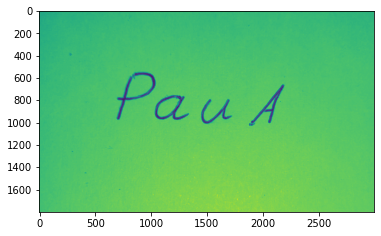

In [25]:
image = io.imread('/content/Lithuanian_OCR/Examples/example3.jpg')

# image = rotate(image, 90)
image = rgb2gray(image)
image = resize(image, (1800, 3000))
plt.imshow(image)